In [1]:
from helpers import *

In [2]:
df = pd.read_csv("rfm_and_delay.csv")
print(df.shape)
df.head()

(96096, 6)


,recency_score,frequency_score,monetary_score,rfm_score,avg_satisfaction,avg_delivery_delay
0,4,1,4,414,5.0,6.0
1,4,1,1,411,4.0,3.0
2,1,1,2,112,3.0,25.0
3,2,1,1,211,4.0,20.0
4,2,1,5,215,5.0,13.0


## TSNE with PCA & with reviews

In [3]:
df

,recency_score,frequency_score,monetary_score,rfm_score,avg_satisfaction,avg_delivery_delay
0,4,1,4,414,5.0,6.0
1,4,1,1,411,4.0,3.0
2,1,1,2,112,3.0,25.0
3,2,1,1,211,4.0,20.0
4,2,1,5,215,5.0,13.0
...,...,...,...,...,...,...
96091,1,1,5,115,5.0,27.0
96092,3,1,2,312,4.0,30.0
96093,1,1,3,113,5.0,14.0
96094,4,1,4,414,5.0,11.0


In [4]:
tsne = TSNE(random_state=42)
X_tsne_pca = tsne.fit_transform(df)

Text(0.5, 1.0, 'TSNE without PCA')

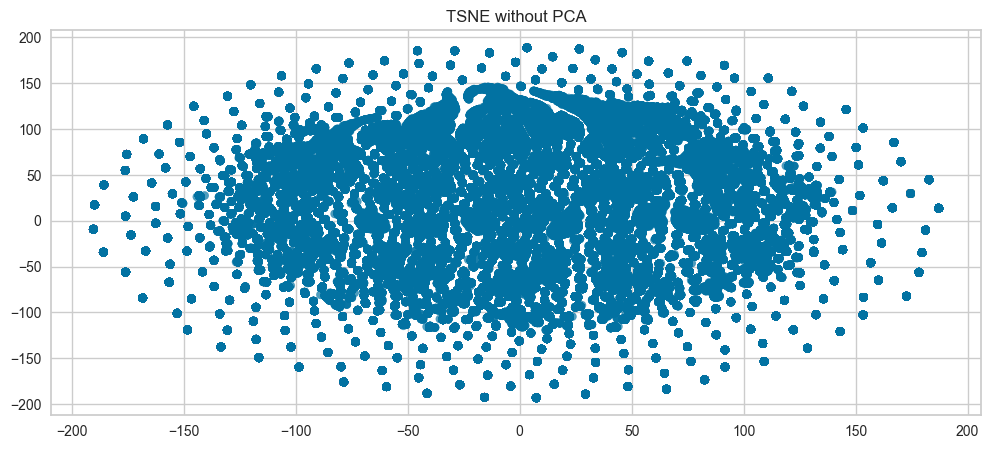

In [5]:
plt.figure(figsize=(12,5))
plt.scatter(X_tsne_pca[:, 0], X_tsne_pca[:, 1],
            edgecolor='none', alpha=0.7, s=40)
plt.title('TSNE without PCA')

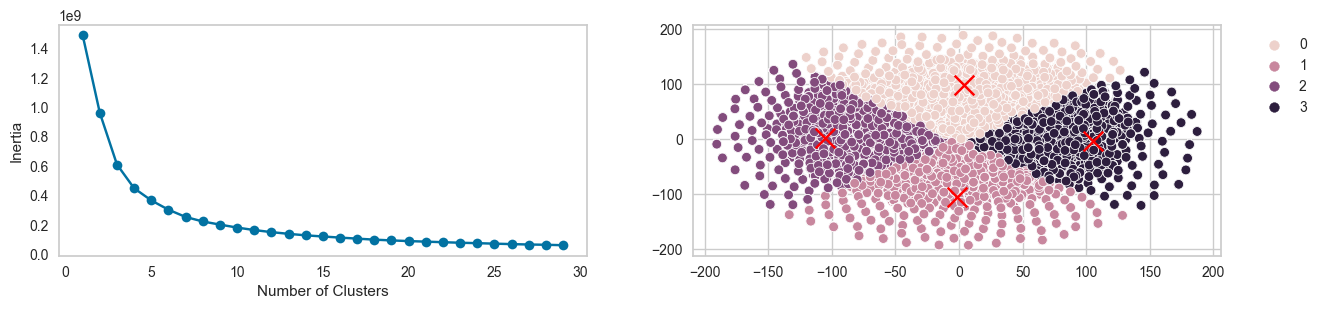

<Figure size 1000x300 with 0 Axes>

In [6]:
show_segmentation(X_tsne_pca, 4)

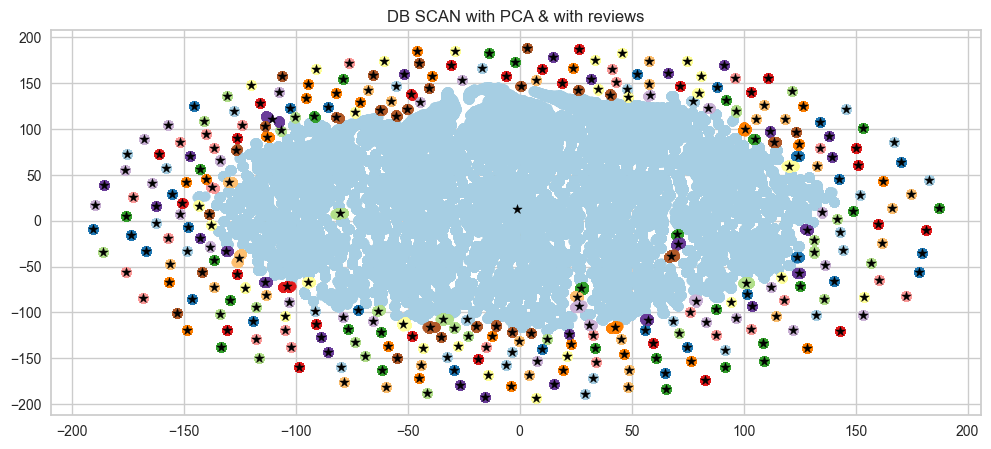

n_clusters 320


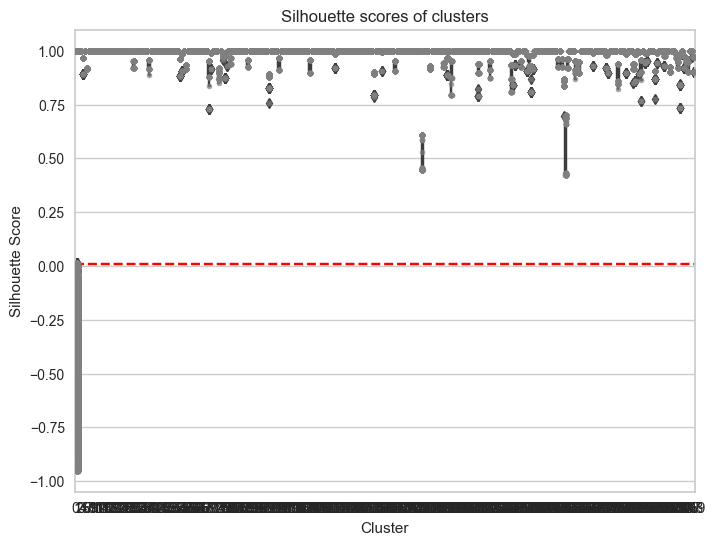

In [7]:
cluster_label = do_dbscan(X_tsne_pca, "DB SCAN with PCA & with reviews")

#### PCA Explainability (without review)

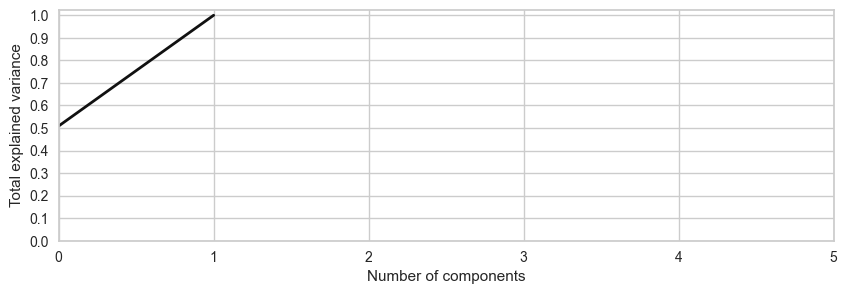

In [8]:
pca = PCA().fit(X_tsne_pca)

plt.figure(figsize=(10,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 5)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [9]:
# perform PCA on the data  
pca = PCA(n_components=1)  
pca.fit(df)  
  
# get the loadings for the first principal component  
loadings = pca.components_[0]  
  
# create a dataframe to display the loadings  
loadings_df = pd.DataFrame({'Feature': df.columns, 'Loading': loadings})  
loadings_df = loadings_df.sort_values('Loading', ascending=False)  
  
print(loadings_df)  

              Feature   Loading
3           rfm_score  0.999928
0       recency_score  0.009961
2      monetary_score  0.000362
1     frequency_score  0.000344
4    avg_satisfaction  0.000338
5  avg_delivery_delay -0.006606


In [10]:
explained_variance = pca.explained_variance_ratio_[0] # explained variance of the first principal component  
feature_contrib = loadings_df['Loading'].apply(lambda x: x**2)  
loadings_df["Contribution"] = round(feature_contrib / feature_contrib.sum() * explained_variance,5) 

In [11]:
loadings_df

,Feature,Loading,Contribution
3,rfm_score,0.999928,0.99506
0,recency_score,0.009961,0.00010
2,monetary_score,0.000362,0.00000
1,frequency_score,0.000344,0.00000
4,avg_satisfaction,0.000338,0.00000
5,avg_delivery_delay,-0.006606,0.00004


In [14]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Clusters mean",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [12]:
from sklearn.compose import ColumnTransformer, make_column_transformer

X_test = pd.DataFrame(df, index=df.index, columns=df.columns)
X_test["cluster_labels"] = cluster_label

X_test_clusters = X_test.groupby("cluster_labels").mean()
X_test_clusters

,recency_score,frequency_score,monetary_score,rfm_score,avg_satisfaction,avg_delivery_delay
cluster_labels,,,,,,
0,4.000000,1.000000,4.000000,414.000000,5.000000,6.000000
1,2.943353,1.211884,3.097723,309.551822,3.399821,13.969746
2,2.000000,1.000000,5.000000,215.000000,5.000000,13.000000
3,2.000000,1.000000,3.000000,213.000000,5.000000,10.000000
4,4.000000,1.000000,2.000000,412.000000,5.000000,15.000000
...,...,...,...,...,...,...
315,2.000000,1.000000,4.000000,214.000000,5.000000,19.000000
316,3.000000,1.000000,2.000000,312.000000,5.000000,3.000000
317,3.000000,1.000000,1.000000,311.000000,4.000000,7.000000


In [15]:
plot_radars(data=X_test_clusters, group="cluster_labels")